### Data Profiling ###
Some further data profiling action with the new prepared usage_stats file.

In [4]:
#import libraries
%matplotlib inline

import seaborn as sns
import pandas as pd
import pysal as ps
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium as fo
import folium.plugins as plugins
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from datetime import datetime, timedelta
from folium.plugins import HeatMap

In [5]:
df_stations = pd.read_csv("usage_stats_cleaned.csv")
df_stations.rename(columns = {'StartStation  latitude':'StartStation latitude', 'EndStation  latitude':'EndStation latitude'}, inplace = True)

In [6]:
print(df_stations.count())
df_stations[df_stations["StartStation Id"] == 1].head()

#geolocator = Nominatim(domain="141.59.29.115/nominatim/", scheme="http", timeout=100)

def distance(row):
    """Get distance between pairs of lat-lon points"""
    return geodesic((row["StartStation latitude"], row["StartStation longitude"]), 
                    (row["EndStation latitude"], row["EndStation longitude"])).km

df_stations['distance (geodesic)'] = df_stations.apply(lambda row: distance(row),axis=1)
df_stations.head()


StartStation Id           6643573
EndStation Id             6643573
Duration                  6643573
StartStation Id Used      6643573
EndStation Id Used        6643573
StartStation Address      6643573
StartStation latitude     6643573
StartStation longitude    6643573
StartStation capacity     6643573
EndStation Address        6643573
EndStation latitude       6643573
EndStation longitude      6643573
EndStation capacity       6643573
dtype: int64


,StartStation Id,EndStation Id,Duration,StartStation Id Used,EndStation Id Used,StartStation Address,StartStation latitude,StartStation longitude,StartStation capacity,EndStation Address,EndStation latitude,EndStation longitude,EndStation capacity,distance (geodesic)
0,463,148,3720,21394,47890,"Thurtle Road, Haggerston",51.534776,-0.071881,22,"Tachbrook Street, Victoria",51.492111,-0.138365,16,6.620659
1,833,148,2400,5671,47890,"Saltoun Road, Brixton",51.460232,-0.115375,42,"Tachbrook Street, Victoria",51.492111,-0.138365,16,3.889870
2,833,148,1440,5671,47890,"Saltoun Road, Brixton",51.460232,-0.115375,42,"Tachbrook Street, Victoria",51.492111,-0.138365,16,3.889870
3,833,148,1380,5671,47890,"Saltoun Road, Brixton",51.460232,-0.115375,42,"Tachbrook Street, Victoria",51.492111,-0.138365,16,3.889870
4,833,148,1140,5671,47890,"Saltoun Road, Brixton",51.460232,-0.115375,42,"Tachbrook Street, Victoria",51.492111,-0.138365,16,3.889870


In [7]:
#Max distance
print(df_stations.iloc[df_stations["distance (geodesic)"].idxmax()])
#Min distance
df_stations.iloc[df_stations["distance (geodesic)"].idxmin()]

StartStation Id                                    790
EndStation Id                                      694
Duration                                          4200
StartStation Id Used                             23992
EndStation Id Used                               15593
StartStation Address      Stratford Station, Stratford
StartStation latitude                          51.5418
StartStation longitude                        -0.00481
StartStation capacity                               28
EndStation Address         Putney Rail Station, Putney
EndStation latitude                            51.4607
EndStation longitude                         -0.216526
EndStation capacity                                 20
distance (geodesic)                             17.248
Name: 1308087, dtype: object


StartStation Id                                    273
EndStation Id                                      819
Duration                                          8280
StartStation Id Used                             75013
EndStation Id Used                               23772
StartStation Address      Belvedere Road 1, South Bank
StartStation latitude                          51.5061
StartStation longitude                       -0.114686
StartStation capacity                               38
EndStation Address        Belvedere Road 2, South Bank
EndStation latitude                            51.5062
EndStation longitude                         -0.114842
EndStation capacity                                 38
distance (geodesic)                          0.0137722
Name: 2600502, dtype: object

In [8]:
#Set list of relevance
dr_list = ["EndStation Id",
           "EndStation Id Used",
           "StartStation Address",
           "EndStation Address",
           "EndStation latitude",
           "EndStation longitude",
           "EndStation capacity",
           "distance (geodesic)"
]
df_startStations = df_stations.drop(dr_list, axis = 1)
#Unique stations
df_startStations.drop_duplicates(subset=("StartStation Id"), keep="first", inplace=True)
print(df_startStations.count())
df_startStations.dropna(0, inplace=True)
df_startStations.head()

#Add distances 

StartStation Id           783
Duration                  783
StartStation Id Used      783
StartStation latitude     783
StartStation longitude    783
StartStation capacity     783
dtype: int64


,StartStation Id,Duration,StartStation Id Used,StartStation latitude,StartStation longitude,StartStation capacity
0,463,3720,21394,51.534776,-0.071881,22
1,833,2400,5671,51.460232,-0.115375,42
7,243,360,53884,51.490963,-0.139625,25
84,392,1500,69386,51.499429,-0.179702,21
91,540,1380,41120,51.528302,-0.144466,27


In [9]:
df_startStations["StartStation capacity"] = df_startStations["StartStation capacity"].astype("str")
df_startStations["StartStation Id Used"] = df_startStations["StartStation Id Used"].astype("float64")
df_startStations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783 entries, 0 to 43180
Data columns (total 6 columns):
StartStation Id           783 non-null int64
Duration                  783 non-null int64
StartStation Id Used      783 non-null float64
StartStation latitude     783 non-null float64
StartStation longitude    783 non-null float64
StartStation capacity     783 non-null object
dtypes: float64(3), int64(2), object(1)
memory usage: 42.8+ KB


In [10]:
#Plot most used rental stations
import os

m = fo.Map(
    location=(51.509865, -0.118092),
    zoom_start= 10
)


df_startStations_top = df_startStations.sort_values(by=['StartStation Id Used'], ascending=False)[:1]
#top markers
for index, p in df_startStations_top[['StartStation latitude','StartStation longitude','StartStation capacity', 'StartStation Id Used']].iterrows():
    fo.Marker(
    location=[p['StartStation latitude'], p['StartStation longitude']],
    icon=fo.Icon(color='red'),
    popup="Capacity: " + p['StartStation capacity'] + '</br>' + " Used between 2016 and 2018: " + str(p['StartStation Id Used']),
    ).add_to(m)
    
df_startStations_rest = df_startStations.sort_values(by=['StartStation Id Used'], ascending=False)[1:10]
#rest markers
for index, p in df_startStations_rest[['StartStation latitude','StartStation longitude','StartStation capacity', 'StartStation Id Used']].iterrows():
    fo.Marker(
    location=[p['StartStation latitude'], p['StartStation longitude']],
    icon=fo.Icon(color='green'),
    popup="Capacity: " + p['StartStation capacity'] + '</br>' + " Used between 2016 and 2018: " + str(p['StartStation Id Used']),
    ).add_to(m)
    
    
# Circle marker
fo.CircleMarker([51.509865, -0.118092],
                    radius=10,
                    popup='Centroid',
                    color='darkred',
                    fill_opacity=0.2
                    ).add_to(m)


#For Normalizing reasons
max_amount = float(df_startStations['StartStation Id Used'].max())

hm_wide = HeatMap(list(zip(df_startStations["StartStation latitude"].values, df_startStations["StartStation longitude"].values, df_startStations["StartStation Id Used"].values)),
                   min_opacity=0.4,
                   max_val=max_amount,
                   radius=17, blur=15, 
                   max_zoom=8, 
                 )

hm_wide.add_to(m)
m.save(outfile= "most_stations.html")
m

In [12]:
#Plot with folium

m = fo.Map(
    location=(51.509865, -0.118092),
    zoom_start= 12
)


#For Normalizing reasons
max_amount = float(df_startStations['StartStation Id Used'].max())

hm_wide = HeatMap(list(zip(df_startStations["StartStation latitude"].values, df_startStations["StartStation longitude"].values, df_startStations["StartStation Id Used"].values)),
                   min_opacity=0.4,
                   max_val=max_amount,
                   radius=17, blur=15, 
                   max_zoom=8, 
                 )

hm_wide.add_to(m)
m

#### Next steps ####
* Use time data (departure and arrival times) of each station (HeatMapWithTime)
* Try to plot routes between StartStation and EndStation (distance calculation with Nominatim server)

,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,SUB_2009,SUB_2006,geometry
0,Kingston upon Thames,E09000021,3726.117,0.000,F,None,None,"POLYGON ((516401.6 160201.8, 516407.3 160210.5..."
1,Croydon,E09000008,8649.441,0.000,F,None,None,"POLYGON ((535009.2 159504.7, 535005.5 159502, ..."
2,Bromley,E09000006,15013.487,0.000,F,None,None,"POLYGON ((540373.6 157530.4, 540361.2 157551.9..."
3,Hounslow,E09000018,5658.541,60.755,F,None,None,"POLYGON ((521975.8 178100, 521967.7 178096.8, ..."
4,Ealing,E09000009,5554.428,0.000,F,None,None,"POLYGON ((510253.5 182881.6, 510249.9 182886, ..."


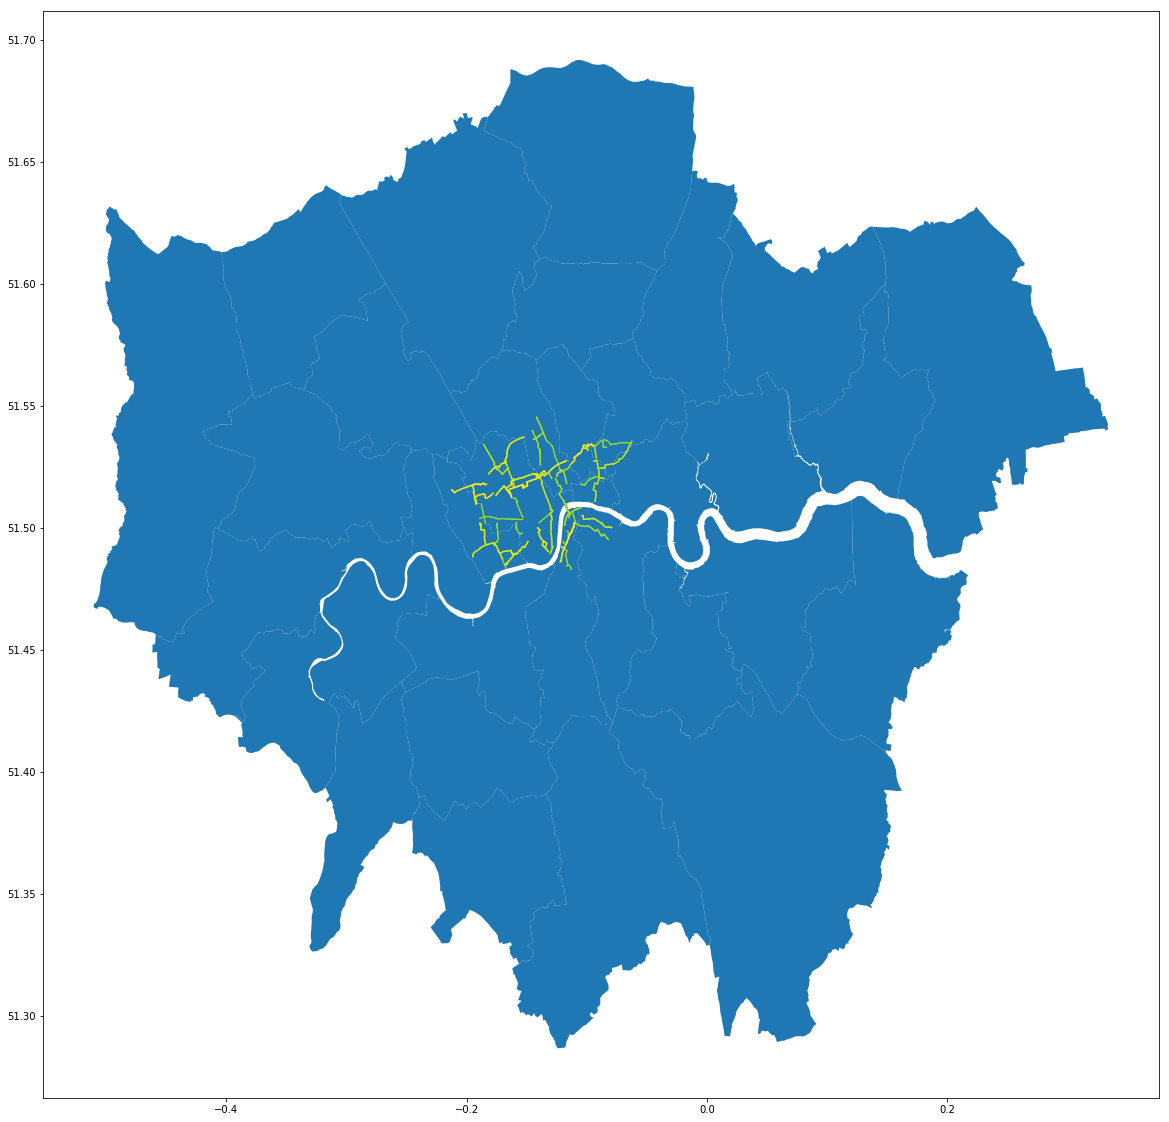

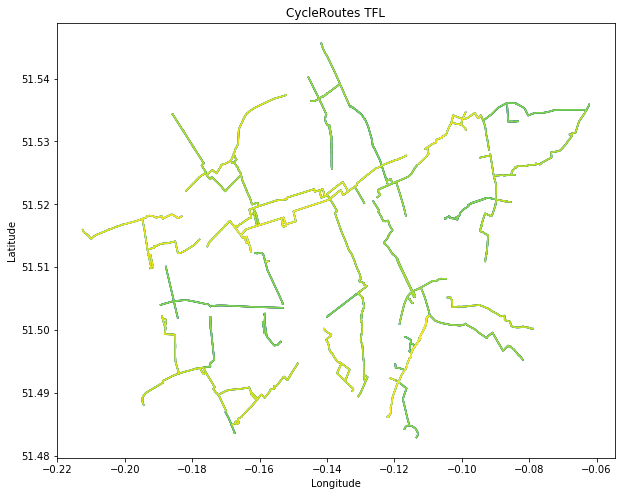

In [13]:
#Read ward shape file
london_gdf = gpd.read_file("statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp")
#read cycleroutes shape file
gpd_cycleroutes = gpd.read_file("CycleRoutes_Cleaned.shp")
gpd_cycleroutes.head()

#Plot choropleth
f, ax = plt.subplots(1,figsize=(20, 20))
gpd_cycleroutes.plot(ax = ax, cmap="viridis", alpha=1, legend=True)
london_gdf.to_crs(epsg="4326").plot(ax=ax)

f, ax = plt.subplots(1, figsize=(10,8))
gpd_cycleroutes.plot(ax = ax, cmap="viridis", alpha=1, legend=True)
plt.title("CycleRoutes TFL")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

london_gdf.head()




In [14]:
gpd_central = gpd_cycleroutes[gpd_cycleroutes.gridType == "Central_London_Grid"]

# create a map showing Baden-Württemberg
m = fo.Map(
 #   [48.661604,9.350134],
    zoom_start=8,
    world_copy_jump=True,
    no_wrap=False,  
)

# add markers for plants
#for index, row in df.iterrows():
   # fo.Marker(location=[row["lat"], row["lon"]], popup=row["Status"]).add_to(m)
    
m